In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler, MinMaxScaler, Normalizer


Using TensorFlow backend.


In [2]:
# Data load
print('Loading Data...')
train_activity = pd.read_csv('./train/train_activity.csv', encoding='cp949')
train_label = pd.read_csv('./train/train_label.csv', encoding='cp949')
train_party = pd.read_csv('./train/train_party.csv', encoding='cp949')
train_payment = pd.read_csv('./train/train_payment.csv', encoding='cp949')
train_trade = pd.read_csv('./train/train_trade.csv', encoding='cp949')
train_guild = pd.read_csv('./train/train_guild.csv', encoding='cp949')

test_activity = pd.read_csv('./test/test_activity.csv', encoding='cp949')
test_party = pd.read_csv('./test/test_party.csv', encoding='cp949')
test_payment = pd.read_csv('./test/test_payment.csv', encoding='cp949')
test_trade = pd.read_csv('./test/test_trade.csv', encoding='cp949')
test_guild = pd.read_csv('./test/test_guild.csv', encoding='cp949')

Loading Data...


In [3]:
# 'acc_id'가 같은 row들을 하나의 row로 sum
# as_index=False  groupby를 할 때 기준이 되는 key가 사라지지 않도록 함.
# sort=False groupby 이후 자동정렬하지 않도록 함.
train_activity_sum = train_activity.groupby(['acc_id'], as_index=False, sort=False).sum() # 100000 rows × 38 columns
train_payment_sum = train_payment.groupby(['acc_id'], as_index=False, sort=False).sum()

test_activity_sum = test_activity.groupby(['acc_id'], as_index=False, sort=False).sum() 
test_payment_sum = test_payment.groupby(['acc_id'], as_index=False, sort=False).sum()

In [4]:
train_guild_copy = train_guild.copy()
test_guild_copy = test_guild.copy()

In [5]:
# Guild에 속한 ID row로 분해
# ref: https://stackoverflow.com/questions/38651008/splitting-multiple-columns-into-rows-in-pandas-dataframe
train_guild_member = train_guild_copy.guild_member_acc_id.str.split(',', expand=True).stack().str.strip().reset_index(level=1, drop=True)
train_guild_member = pd.concat([train_guild_member], axis=1, keys=['acc_id'])

test_guild_member = test_guild_copy.guild_member_acc_id.str.split(',', expand=True).stack().str.strip().reset_index(level=1, drop=True)
test_guild_member = pd.concat([test_guild_member], axis=1, keys=['acc_id'])

In [6]:
# 기존의 guild_member_acc_id를 지우고 guild_member의 컬럼들을 추가
train_guild_copy = train_guild_copy.drop(['guild_member_acc_id'], axis=1).join(train_guild_member).reset_index(drop=True)

test_guild_copy = test_guild_copy.drop(['guild_member_acc_id'], axis=1).join(test_guild_member).reset_index(drop=True)

In [7]:
# guild_id = 0: 길드를 가입하지 않은 유저
# guild_id = 1: 길드를 가입한 유저
train_guild_act = pd.merge(train_guild_copy, train_activity_sum, how='right', sort=False).fillna(0)
mask = train_guild_act['guild_id'] != 0
column_name = 'guild_id'
train_guild_act.loc[mask, column_name] = 1

test_guild_act = pd.merge(test_guild_copy, test_activity_sum, how='right', sort=False).fillna(0)
mask = test_guild_act['guild_id'] != 0
column_name = 'guild_id'
test_guild_act.loc[mask, column_name] = 1

In [8]:
# 하나의 row로 합치기
# 길드 소속이 2개 이상인 계정 통합
train_guild_act = train_guild_act.groupby(['acc_id'], as_index=False, sort=False).mean()

test_guild_act = test_guild_act.groupby(['acc_id'], as_index=False, sort=False).mean()

# guild_id -> guild  column 이름 변경
train_guild_act = train_guild_act.rename(columns={'guild_id': 'guild'})
test_guild_act = test_guild_act.rename(columns={'guild_id': 'guild'})

In [9]:
# 길드에 소속된 계정만 출력
# train_guild_act.loc[train_guild_act['guild'] == 0]

In [10]:
# test_guild_act.loc[test_guild_act['guild'] == 0]

In [11]:
# payment 테이블 merge
train_data = pd.merge(train_guild_act, train_payment_sum.drop(columns=['payment_week']), how='outer', sort=False)

test_data = pd.merge(test_guild_act, test_payment_sum.drop(columns=['payment_week']), how='outer', sort=False)

In [12]:
# train label file encoding (scikit learn Label Encoding은 자동정렬을 하기 때문에 사용하지 않음)
# ref: https://stackoverflow.com/questions/42196589/any-way-to-get-mappings-of-a-label-encoder-in-python-pandas
# train_label_en = pd.DataFrame({'label':pd.Categorical(train_label.label,  ['week', 'month', '2month', 'retained']).labels, 'acc_id':train_label.acc_id})
# print(train_label_en)

In [13]:
# Encoding 부분
# Onehot Encoding을 위해 Int 형으로 데이터 변환
label_encoder = LabelEncoder()
int_encoded = label_encoder.fit_transform(train_label.label)
# shape 모양 형태 변환 (#data,) -> (#data,1)
int_encoded = int_encoded.reshape(len(int_encoded),1)

In [14]:
onthot_encoder = OneHotEncoder(sparse=False)
onehot_encoded = onthot_encoder.fit_transform(int_encoded)

In [15]:
train_label_en = pd.concat([train_label, pd.DataFrame(onehot_encoded, columns=['2month', 'month', 'retained', 'week'])], axis=1)
train_label_en = train_label_en.drop(columns=['label'])

pd.merge(train_data, train_label, sort=False)
pd.merge(train_data, train_label_en, sort=False)
두 개 비교를 통해서 레이블이 제대로 인코딩 되었는지 확인할 수 있음

In [16]:
#pd.merge(train_data, train_label, sort=False)

In [17]:
#pd.merge(train_data, train_label_en, sort=False)

In [18]:
train_data = pd.merge(train_data, train_label_en, sort=False)

In [19]:
# duel ratio: 승 / 참여 횟수
train_data['duel_winRatio'] = train_data['duel_win'] / train_data['duel_cnt']
train_data = train_data.drop(columns=['duel_win', 'duel_cnt'])

test_data['duel_winRatio'] = test_data['duel_win'] / test_data['duel_cnt']
test_data = test_data.drop(columns=['duel_win', 'duel_cnt'])

In [20]:
# partybattle ratio: 승 / 참여 횟수
train_data['partybattle_winRatio'] = train_data['partybattle_win'] / train_data['partybattle_cnt']
train_data = train_data.drop(columns=['partybattle_win', 'partybattle_cnt'])

test_data['partybattle_winRatio'] = test_data['partybattle_win'] / test_data['partybattle_cnt']
test_data = test_data.drop(columns=['partybattle_win', 'partybattle_cnt'])

In [21]:
# solo clear ratio: 완료 횟수 / 입장 횟수
train_data['inzone_solo_clearRatio'] = train_data['cnt_clear_inzone_solo'] / train_data['cnt_enter_inzone_solo']
train_data = train_data.drop(columns=['cnt_clear_inzone_solo', 'cnt_enter_inzone_solo'])

test_data['inzone_solo_clearRatio'] = test_data['cnt_clear_inzone_solo'] / test_data['cnt_enter_inzone_solo']
test_data = test_data.drop(columns=['cnt_clear_inzone_solo', 'cnt_enter_inzone_solo'])

In [22]:
# light clear ratio: 완료 횟수 / 입장 횟수
train_data['inzone_light_clearRatio'] = train_data['cnt_clear_inzone_light'] / train_data['cnt_enter_inzone_light']
train_data = train_data.drop(columns=['cnt_clear_inzone_light', 'cnt_enter_inzone_light'])

test_data['inzone_light_clearRatio'] = test_data['cnt_clear_inzone_light'] / test_data['cnt_enter_inzone_light']
test_data = test_data.drop(columns=['cnt_clear_inzone_light', 'cnt_enter_inzone_light'])

In [23]:
# skilled clear ratio: 완료 횟수 / 입장 횟수
train_data['inzone_skilled_clearRatio'] = train_data['cnt_clear_inzone_skilled'] / train_data['cnt_enter_inzone_skilled']
train_data = train_data.drop(columns=['cnt_clear_inzone_skilled', 'cnt_enter_inzone_skilled'])

test_data['inzone_skilled_clearRatio'] = test_data['cnt_clear_inzone_skilled'] / test_data['cnt_enter_inzone_skilled']
test_data = test_data.drop(columns=['cnt_clear_inzone_skilled', 'cnt_enter_inzone_skilled'])

In [24]:
# normal clear ratio: 완료 횟수 / 입장 횟수
train_data['inzone_skilled_clearRatio'] = train_data['cnt_clear_inzone_normal'] / train_data['cnt_enter_inzone_normal']
train_data = train_data.drop(columns=['cnt_clear_inzone_normal', 'cnt_enter_inzone_normal'])

test_data['inzone_skilled_clearRatio'] = test_data['cnt_clear_inzone_normal'] / test_data['cnt_enter_inzone_normal']
test_data = test_data.drop(columns=['cnt_clear_inzone_normal', 'cnt_enter_inzone_normal'])

In [25]:
# raid clear ratio: 완료 횟수 / 입장 횟수
train_data['raid_clearRatio'] = train_data['cnt_clear_raid'] / train_data['cnt_enter_raid']
train_data = train_data.drop(columns=['cnt_clear_raid', 'cnt_enter_raid'])

test_data['raid_clearRatio'] = test_data['cnt_clear_raid'] / test_data['cnt_enter_raid']
test_data = test_data.drop(columns=['cnt_clear_raid', 'cnt_enter_raid'])

In [26]:
# raid light clear ratio: 완료 횟수 / 입장 횟수
train_data['raid_light_clearRatio'] = train_data['cnt_clear_raid_light'] / train_data['cnt_enter_raid_light']
train_data = train_data.drop(columns=['cnt_clear_raid_light', 'cnt_enter_raid_light'])

test_data['raid_light_clearRatio'] = test_data['cnt_clear_raid_light'] / test_data['cnt_enter_raid_light']
test_data = test_data.drop(columns=['cnt_clear_raid_light', 'cnt_enter_raid_light'])

In [27]:
# bam clear ratio: 완료 횟수 / 입장 횟수
train_data['bam_clearRatio'] = train_data['cnt_clear_bam'] / train_data['cnt_enter_bam']
train_data = train_data.drop(columns=['cnt_clear_bam', 'cnt_enter_bam'])

test_data['bam_clearRatio'] = test_data['cnt_clear_bam'] / test_data['cnt_enter_bam']
test_data = test_data.drop(columns=['cnt_clear_bam', 'cnt_enter_bam'])

In [28]:
# chat: 모든 채팅 횟수의 합
train_data['chat'] = train_data['normal_chat'] + train_data['whisper_chat'] + train_data['district_chat'] + train_data['party_chat'] + train_data['guild_chat'] + train_data['faction_chat']
train_data = train_data.drop(columns=['normal_chat', 'whisper_chat', 'district_chat', 'party_chat', 'guild_chat', 'faction_chat'])

test_data['chat'] = test_data['normal_chat'] + test_data['whisper_chat'] + test_data['district_chat'] + test_data['party_chat'] + test_data['guild_chat'] + test_data['faction_chat']
test_data = test_data.drop(columns=['normal_chat', 'whisper_chat', 'district_chat', 'party_chat', 'guild_chat', 'faction_chat'])

In [29]:
# wk 활동 시기 삭제
train_data = train_data.drop(columns=['wk'])
test_data = test_data.drop(columns=['wk'])

train_data = train_data.drop(columns=['cnt_dt'])
test_data = test_data.drop(columns=['cnt_dt'])

In [30]:
# exp: 모든 경험치의 합
train_data['exp'] = train_data['npc_exp'] + train_data['npc_hongmun'] + train_data['quest_exp'] + train_data['quest_hongmun'] + train_data['item_hongmun']
train_data = train_data.drop(columns=['npc_exp', 'npc_hongmun', 'quest_exp', 'quest_hongmun', 'item_hongmun'])

test_data['exp'] = test_data['npc_exp'] + test_data['npc_hongmun'] + test_data['quest_exp'] + test_data['quest_hongmun'] + test_data['item_hongmun']
test_data = test_data.drop(columns=['npc_exp', 'npc_hongmun', 'quest_exp', 'quest_hongmun', 'item_hongmun'])

In [31]:
# play_time / cnt_dt  하루 평균 게임 이용 시간 ( 데이터 비교해보기 )


In [32]:
# party data 활용
train_party_copy = train_party.copy()
test_party_copy = test_party.copy()

In [33]:
train_party_copy['party_start_day'] = (train_party_copy['party_start_week'] - 1) * 7 + train_party_copy['party_start_day']
train_party_copy['party_end_day'] = (train_party_copy['party_end_week'] - 1) * 7 + train_party_copy['party_end_day']
train_party_copy = train_party_copy.drop(columns=['party_start_week', 'party_end_week'])

test_party_copy['party_start_day'] = (test_party_copy['party_start_week'] - 1) * 7 + test_party_copy['party_start_day']
test_party_copy['party_end_day'] = (test_party_copy['party_end_week'] - 1) * 7 + test_party_copy['party_end_day']
test_party_copy = test_party_copy.drop(columns=['party_start_week', 'party_end_week'])

In [34]:
# party_time = (end time - start time) + (end day - start day)
# to_timedelta을 이용해서 days로 입력하기 위해 스트링으로 변환 후 day값에 days을 붙여줌
# party_time은 파티를 한 시간(단위:초)
# 시간 변환 ref: https://stackoverflow.com/questions/26566107/how-to-convert-numpy-timedelta64-to-minutes
train_party_copy['party_day'] = (train_party_copy['party_end_day'] - train_party_copy['party_start_day']).astype('str')
train_party_copy['party_day'] = train_party_copy['party_day'] + ' days'
train_party_copy['party_time'] = (pd.to_timedelta(train_party_copy['party_end_time']) - pd.to_timedelta(train_party_copy['party_start_time']) + pd.to_timedelta(train_party_copy['party_day'])).astype('timedelta64[s]')

test_party_copy['party_day'] = (test_party_copy['party_end_day'] - test_party_copy['party_start_day']).astype('str')
test_party_copy['party_day'] = test_party_copy['party_day'] + ' days'
test_party_copy['party_time'] = (pd.to_timedelta(test_party_copy['party_end_time']) - pd.to_timedelta(test_party_copy['party_start_time']) + pd.to_timedelta(test_party_copy['party_day'])).astype('timedelta64[s]')

# 다 사용한 컬럼들 제거
train_party_copy = train_party_copy.drop(columns=['party_start_day', 'party_end_day', 'party_start_time', 'party_end_time', 'party_day'])
test_party_copy = test_party_copy.drop(columns=['party_start_day', 'party_end_day', 'party_start_time', 'party_end_time', 'party_day'])

In [35]:
train_party_copy1 = train_party_copy[:2300000]
train_party_copy2 = train_party_copy[2300000:4600000]
train_party_copy3 = train_party_copy[4600000:]

test_party_copy1 = test_party_copy[:2000000]
test_party_copy2 = test_party_copy[2000000:]

In [36]:
print(len(train_party_copy1))
print(len(train_party_copy2))
print(len(train_party_copy3))

print(len(test_party_copy1))
print(len(test_party_copy2))

2300000
2300000
2362341
2000000
2121512


In [37]:
train_party_member1 = train_party_copy1.hashed.str.split(',', expand=True).stack().str.strip().reset_index(level=1, drop=True)
train_party_member1 = pd.concat([train_party_member1], axis=1, keys=['acc_id'])

In [38]:
train_party_member2 = train_party_copy2.hashed.str.split(',', expand=True).stack().str.strip().reset_index(level=1, drop=True)
train_party_member2 = pd.concat([train_party_member2], axis=1, keys=['acc_id'])

In [39]:
train_party_member3 = train_party_copy3.hashed.str.split(',', expand=True).stack().str.strip().reset_index(level=1, drop=True)
train_party_member3 = pd.concat([train_party_member3], axis=1, keys=['acc_id'])

In [40]:
test_party_member1 = test_party_copy1.hashed.str.split(',', expand=True).stack().str.strip().reset_index(level=1, drop=True)
test_party_member1 = pd.concat([test_party_member1], axis=1, keys=['acc_id'])

In [41]:
test_party_member2 = test_party_copy2.hashed.str.split(',', expand=True).stack().str.strip().reset_index(level=1, drop=True)
test_party_member2 = pd.concat([test_party_member2], axis=1, keys=['acc_id'])

In [42]:
test_party_member2

,acc_id
2000000,05e7c6d3cc77c8a0f334de91ad4562e5771f1f01cc259c...
2000000,0b1c002721aa464ef2637579032e32173a8069dde2b629...
2000000,b85ac8b1fe2064df0551d409c5fd3b1d77424ace952fbb...
2000000,f1701d2509dd9d59d5f60bfda8ddef8051b51b217715d4...
2000000,566fed54ef34cda6c5668f8ea36cb577998d3d7e6c6b40...
2000000,a2747131f4e37676ed5ae2981a5d666b65fa41dafa049e...
2000001,bf3e7941cf8961e6c610b5eeb991df1e2005eefc334e00...
2000001,a5854b5868c56da75920f3409229ef6c85ea7f77927e52...
2000001,62bacce54751b2e7f0d4c4b1c8131885e4299422970eef...
2000001,919678804f1785447e9feb61934beb76556848ee8a25e9...


In [43]:
train_party_copy1 = train_party_copy1.drop(['hashed'], axis=1).join(train_party_member1).reset_index(drop=True)
train_party_copy2 = train_party_copy2.drop(['hashed'], axis=1).join(train_party_member2).reset_index(drop=True)
train_party_copy3 = train_party_copy3.drop(['hashed'], axis=1).join(train_party_member3).reset_index(drop=True)

test_party_copy1 = test_party_copy1.drop(['hashed'], axis=1).join(test_party_member1).reset_index(drop=True)
test_party_copy2 = test_party_copy2.drop(['hashed'], axis=1).join(test_party_member2).reset_index(drop=True)

In [44]:
print(len(train_party_copy1))
print(len(train_party_copy2))
print(len(train_party_copy3))

print(len(test_party_copy1))
print(len(test_party_copy2))

11322117
11323117
11639048
10596258
11253686


In [53]:
train_party_copy = pd.concat([train_party_copy1, train_party_copy2, train_party_copy3], axis=0)
# del train_party_copy1, train_party_copy2, train_party_copy3, train_party_member1, train_party_member2, train_party_member3

test_party_copy = pd.concat([test_party_copy1, test_party_copy2], axis=0)
# del test_party_copy1, test_party_copy2, test_party_member1, test_party_member2

In [54]:
train_party_copy = train_party_copy.groupby(['acc_id'], as_index=False, sort=False).sum() 

test_party_copy = test_party_copy.groupby(['acc_id'], as_index=False, sort=False).sum() 

In [55]:
train_data = pd.merge(train_data, train_party_copy, on='acc_id', how='left').fillna(0)

test_data = pd.merge(test_data, test_party_copy, on='acc_id', how='left').fillna(0)

In [57]:
train_data

,acc_id,guild,play_time,game_combat_time,get_money,cnt_use_buffitem,gathering_cnt,making_cnt,payment_amount,2month,...,partybattle_winRatio,inzone_solo_clearRatio,inzone_light_clearRatio,inzone_skilled_clearRatio,raid_clearRatio,raid_light_clearRatio,bam_clearRatio,chat,exp,party_time
0,ba86804424a9a3708b1564a7726783612a75a5b881095e...,1,2.055999,3.303208,-0.064372,-2.426116,-0.222066,4.332736,2.316438,0.0,...,0.948984,1.095025,0.297051,1.327638,0.886869,1.056563,0.695391,14.999690,9.591816,1762772.0
1,ddea37c9b636c4b1650414052f6ede370481e9e236b193...,1,-0.642371,-0.569842,-0.023543,-0.503692,-0.027758,-0.365536,-1.199188,0.0,...,0.954619,0.992723,1.013358,1.009184,0.998605,0.997774,0.695391,-0.919453,-1.567120,0.0
2,b178c21c7e3a1a404dc6b8048d719f1e33873ab8b05a41...,1,-2.910908,-2.024365,-0.153370,-1.250636,-0.222066,0.825173,0.558625,0.0,...,1.686654,1.059076,0.687376,0.613881,3.415784,0.822299,0.695391,-2.014938,-4.765902,297430.0
3,25810af9e9cff193561a77da73684a3113c3c1539168b1...,1,-1.988991,-2.475399,-0.185975,-2.789053,-0.222066,2.034677,-0.496063,0.0,...,0.954619,0.999424,0.995508,0.946684,0.911289,1.035478,0.695391,-1.096295,-6.858369,152529.0
4,464de00738deff449aabcdfe7f670e2fc0eb9fa3c9cd89...,1,0.910800,2.593565,-0.171723,2.080793,-0.222066,3.727984,-1.199188,0.0,...,1.008542,1.007289,0.533803,0.808588,0.808264,1.029709,1.160394,13.386918,10.732284,783386.0
5,df69740fd9b58b4353ac3d38c1ec38e7f5366a4bdbed9c...,1,5.229929,3.137308,0.061717,5.287633,-0.222066,20.902950,4.425814,0.0,...,0.584934,0.996285,0.365041,1.260774,0.957240,1.008594,0.695391,50.249777,21.409978,1296244.0
6,37273bc48cbb089e8bc6bf3eb3e155c73e1dd745e3606e...,1,-1.373555,-0.824481,-0.179948,-1.738163,-0.222066,3.848934,0.558625,0.0,...,1.817717,0.980472,0.820801,0.745139,1.953363,1.044396,1.160394,-1.050178,6.939676,170986.0
7,03be59a8e01f2f5fdd42e8a74041b69f6b148257214f0c...,1,7.480646,1.806834,-0.106694,-0.958121,-0.222066,4.695588,9.734409,0.0,...,1.161790,0.992723,0.380965,0.576160,0.933803,1.012268,0.695391,17.820267,42.449733,1579330.0
8,80562643e3d956ded3244d6ef950243578d45a74a4e007...,1,5.921157,2.220411,-0.092854,-2.079431,-0.222066,6.026043,1.261750,0.0,...,0.835540,1.002820,0.727982,1.007725,0.977517,1.027486,0.695391,20.627391,14.519981,2736065.0
9,16b864bc8351dc9f27b738a22bbfde3b0355e3be54d191...,1,14.419799,7.250676,0.062136,1.029903,-0.222066,6.146993,17.433630,0.0,...,0.869041,0.986545,0.886157,0.924732,1.073781,1.025326,0.695391,27.482478,53.865746,3140999.0


In [56]:
print(len(train_data.columns)) # label 수 4개
print(len(test_data.columns))

24
20


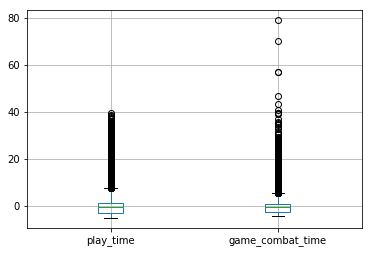

In [93]:
# 데이터 형태 그래프로 확인 후 전처리 작업
plt.figure();
train_data[['play_time', 'game_combat_time']].boxplot()

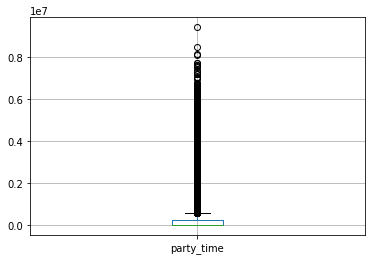

In [58]:
train_data[['party_time']].boxplot()

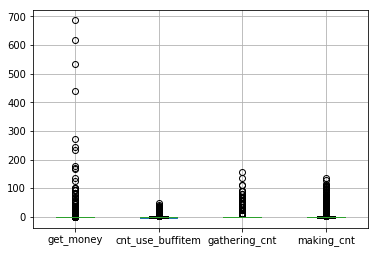

In [94]:
train_data[[ 'get_money', 'cnt_use_buffitem', 'gathering_cnt', 'making_cnt']].boxplot()

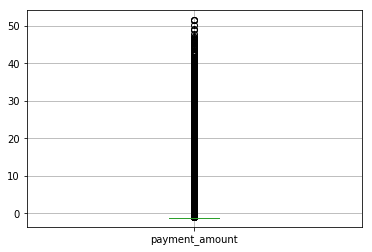

In [95]:
train_data[['payment_amount']].boxplot()

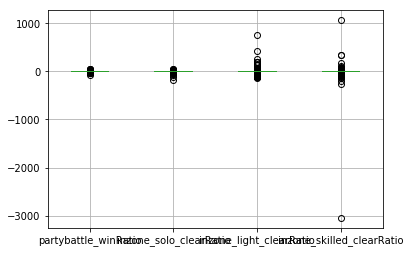

In [96]:
train_data[['partybattle_winRatio', 'inzone_solo_clearRatio', 'inzone_light_clearRatio', 'inzone_skilled_clearRatio',]].boxplot()

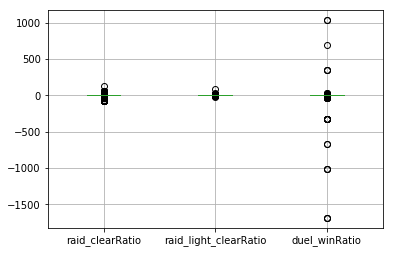

In [97]:
train_data[['raid_clearRatio', 'raid_light_clearRatio', 'duel_winRatio']].boxplot()

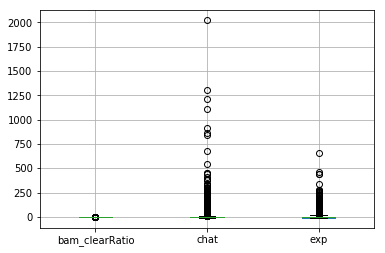

In [98]:
train_data[['bam_clearRatio', 'chat', 'exp']].boxplot()

In [59]:
train_data.describe()

,guild,play_time,game_combat_time,get_money,cnt_use_buffitem,gathering_cnt,making_cnt,payment_amount,2month,month,...,partybattle_winRatio,inzone_solo_clearRatio,inzone_light_clearRatio,inzone_skilled_clearRatio,raid_clearRatio,raid_light_clearRatio,bam_clearRatio,chat,exp,party_time
count,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,...,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,1.000000e+05
mean,0.167360,-0.024753,-0.019596,-0.001839,-0.014227,0.001516,-0.011627,-0.000979,0.250000,0.250000,...,0.949226,0.999162,1.022592,0.992173,1.040412,0.996545,0.694057,-0.013371,-0.079194,3.648309e+05
std,0.373299,4.480034,4.457517,4.252314,4.169045,2.235694,4.682948,4.763623,0.433015,0.433015,...,0.603864,0.985764,3.728899,10.545269,1.737960,0.471722,0.082651,18.061222,12.447042,8.151727e+05
min,0.000000,-5.289304,-4.558735,-0.188343,-4.029536,-0.222066,-2.924292,-1.199188,0.000000,0.000000,...,-84.150483,-187.882137,-131.257439,-3051.347977,-73.618634,-22.926885,-0.051178,-7.399467,-12.536964,0.000000e+00
25%,0.000000,-3.159534,-2.845204,-0.159251,-2.518460,-0.194308,-2.193219,-1.199188,0.000000,0.000000,...,0.954619,0.992723,1.013358,0.996528,0.998605,0.997774,0.695391,-4.624667,-7.830303,0.000000e+00
50%,0.000000,-0.659758,-0.569842,-0.079966,-0.782325,-0.111033,-0.731073,-1.199188,0.000000,0.000000,...,0.954619,0.992723,1.013358,1.009184,0.998605,0.997774,0.695391,-2.010786,-1.567120,5.166000e+03
75%,0.000000,1.093622,0.491120,-0.023543,0.249861,-0.027758,-0.365536,-1.199188,0.250000,0.250000,...,0.954619,0.992723,1.013358,1.009184,0.998605,0.997774,0.695391,-0.924933,2.007881,2.321990e+05
max,1.000000,39.396366,78.867174,686.465532,49.544187,158.125449,137.015398,51.535202,1.000000,1.000000,...,43.236494,54.851032,748.873268,1064.151602,131.363912,85.045149,2.406189,2021.939355,660.643407,9.433841e+06


In [61]:
# 값이 너무 크거나 작은 값 제거
train_data = train_data[train_data.play_time < 4]

train_data = train_data[train_data.game_combat_time < 4]

train_data = train_data[train_data.get_money < 0.5]

train_data = train_data[train_data.gathering_cnt < 5]

train_data = train_data[train_data.making_cnt < 3]

train_data = train_data[train_data.payment_amount < -1.19]

train_data = train_data[(train_data.duel_winRatio > 0.5) & (train_data.duel_winRatio < 1.5)]

train_data = train_data[(train_data.partybattle_winRatio > 0.5) & (train_data.partybattle_winRatio < 1.5)]

train_data = train_data[(train_data.inzone_light_clearRatio > 0.5) & (train_data.inzone_light_clearRatio < 1.5)]

train_data = train_data[(train_data.inzone_solo_clearRatio > 0.5) & (train_data.inzone_solo_clearRatio < 1.5)]

train_data = train_data[(train_data.inzone_skilled_clearRatio > 0.5) & (train_data.inzone_skilled_clearRatio < 1.5)]

train_data = train_data[(train_data.inzone_light_clearRatio > 0.5) & (train_data.inzone_light_clearRatio < 1.5)]

train_data = train_data[(train_data.raid_clearRatio > 0.5) & (train_data.raid_clearRatio < 1.5)]

train_data = train_data[(train_data.raid_light_clearRatio > 0.5) & (train_data.raid_light_clearRatio < 1.5)]

train_data = train_data[train_data.chat <= 5]

train_data = train_data[train_data.exp < 10]


train_data = train_data[train_data.party_time < 232200]


In [63]:
train_data.columns

Index(['acc_id', 'guild', 'play_time', 'game_combat_time', 'get_money',
       'cnt_use_buffitem', 'gathering_cnt', 'making_cnt', 'payment_amount',
       '2month', 'month', 'retained', 'week', 'duel_winRatio',
       'partybattle_winRatio', 'inzone_solo_clearRatio',
       'inzone_light_clearRatio', 'inzone_skilled_clearRatio',
       'raid_clearRatio', 'raid_light_clearRatio', 'bam_clearRatio', 'chat',
       'exp', 'party_time'],
      dtype='object')

In [64]:
# Scaling vs Normalization
# ref: https://www.kaggle.com/rtatman/data-cleaning-challenge-scale-and-normalize-data

# StandardScaler: 기본 스케일. 평균과 표준편차 사용
# MinMaxScaler: 최대/최소값이 각각 1, 0이 되도록 스케일링
# Nomalizer: 데이터의 분포를 바꾸는 것

preprocess_col = ['play_time', 'game_combat_time', 'get_money', 'cnt_use_buffitem', 'gathering_cnt', 'making_cnt','payment_amount', 
 'duel_winRatio', 'partybattle_winRatio', 'inzone_solo_clearRatio','inzone_light_clearRatio', 'inzone_skilled_clearRatio', 
 'raid_clearRatio', 'raid_light_clearRatio', 'bam_clearRatio', 'chat', 'exp', 'party_time']

# scale = StandardScaler()
# scale.fit(train_data[preprocess_col])
# train_data[preprocess_col] = scale.transform(train_data[preprocess_col]) 
# test_data[preprocess_col] = scale.transform(test_data[preprocess_col])

scale = MinMaxScaler()
scale.fit(train_data[preprocess_col])
train_data[preprocess_col] = scale.transform(train_data[preprocess_col]) 
test_data[preprocess_col] = scale.transform(test_data[preprocess_col])

# ref: http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Normalizer.html#sklearn.preprocessing.Normalizer

# nomal = Normalizer()
# nomal.fit(train_data[preprocess_col])
# train_data[preprocess_col] = nomal.transform(train_data[preprocess_col]) 
# test_data[preprocess_col] = nomal.transform(test_data[preprocess_col])

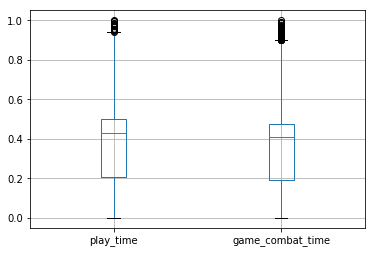

In [65]:
# 노이즈한 데이터 제거 후 그래프로 확인
plt.figure();
train_data[['play_time', 'game_combat_time']].boxplot()

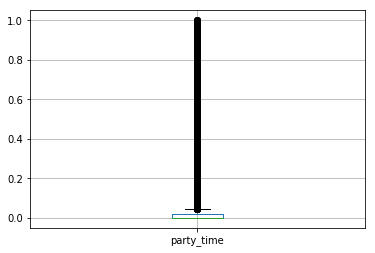

In [68]:
train_data[['party_time']].boxplot()

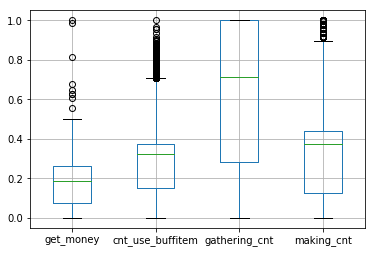

In [69]:
train_data[[ 'get_money', 'cnt_use_buffitem', 'gathering_cnt', 'making_cnt']].boxplot()

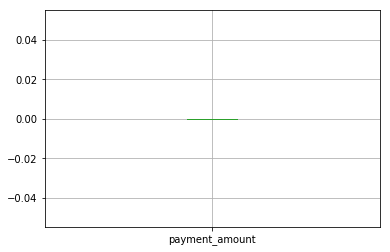

In [70]:
train_data[['payment_amount']].boxplot()

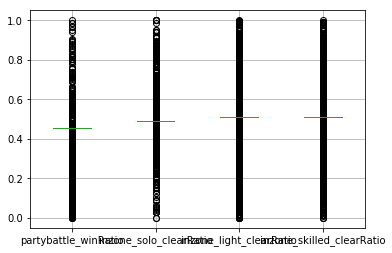

In [71]:
train_data[['partybattle_winRatio', 'inzone_solo_clearRatio', 'inzone_light_clearRatio', 'inzone_skilled_clearRatio',]].boxplot()

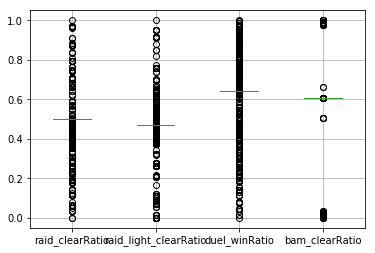

In [72]:
train_data[['raid_clearRatio', 'raid_light_clearRatio', 'duel_winRatio', 'bam_clearRatio']].boxplot()

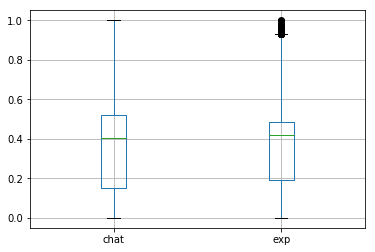

In [73]:
train_data[['chat', 'exp']].boxplot()

(array([53684.,  3265.,  1837.,  1170.,  1087.,   978.,   750.,   600.,
          516.,   362.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

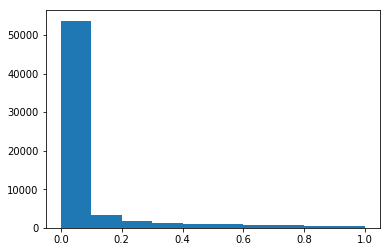

In [74]:
plt.hist(train_data['party_time'])

In [75]:
train_data.to_csv('./train/train_data.csv', index=False)

In [76]:
test_data.to_csv('./test/test_data.csv', index=False)